# Models from the R stemming process

In [23]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
data = pd.read_csv('../../datasets/data-stemmed-R.csv')
data.info()
Y = data['engagement.rate']
X = data.drop(columns=['engagement.rate'])
X.info()
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X)
# Assuming 'X' is a pandas DataFrame with boolean and other types of columns
# columns_to_scale = [col for col in X.columns if col not in X.select_dtypes(include='bool').columns.tolist()]

# scaler = StandardScaler()
# X_scaled = X.copy()
# X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075 entries, 0 to 4074
Columns: 284 entries, chicken to n_emoji
dtypes: bool(9), float64(269), int64(6)
memory usage: 8.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075 entries, 0 to 4074
Columns: 283 entries, chicken to n_emoji
dtypes: bool(9), float64(268), int64(6)
memory usage: 8.6 MB


In [25]:
def CVTest(model, str_model, X, Y, data, reg_metrics: pd.DataFrame, n_splits = 10, top_n_features = 25):
    kf = KFold(n_splits, shuffle=True)
    feature_names= data.drop(columns=['engagement.rate']).columns.tolist()   # Get list of feature names from the dataframe
    total_feature_importance = np.zeros(len(X.columns.tolist()))   # Initialize array to hold feature importances
    for train_index, test_index in kf.split(X):
        start_learn = time.time()
        model.fit(X.iloc[train_index], Y.iloc[train_index])
        end_learn = time.time()
        exe_time_learn = end_learn - start_learn

        # Feature importance calculation for applicable models
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
            total_feature_importance += feature_importance  # Accumulate feature importance for mean calculation
        else:
            print("This model does not provide feature importances.")
        
        start_pred = time.time()
        Y_pred = model.predict(X.iloc[test_index])
        end_pred = time.time()
        exe_time_pred = end_pred - start_pred

        current_mae = mean_absolute_error(Y.iloc[test_index], Y_pred)
        current_mse = mean_squared_error(Y.iloc[test_index], Y_pred)
        current_rmse = mean_squared_error(Y.iloc[test_index], Y_pred, squared=False)
        reg_metrics.loc[len(reg_metrics)] = [str_model.upper(), current_mae, current_mse, current_rmse, exe_time_learn, exe_time_pred]
    
    # Calculate mean importance over all folds
    mean_feature_importance = total_feature_importance / n_splits
    importance_df = pd.DataFrame({'Feature': feature_names, 'Mean Importance': mean_feature_importance})
    top_features = importance_df.nlargest(top_n_features, 'Mean Importance')
    print(f"Top {top_n_features} features based on mean importance over all folds:")
    print(top_features[['Feature', 'Mean Importance']])


In [26]:
reg_metrics_text = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'TIME_LEARN', 'TIME_PREDICT'])

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

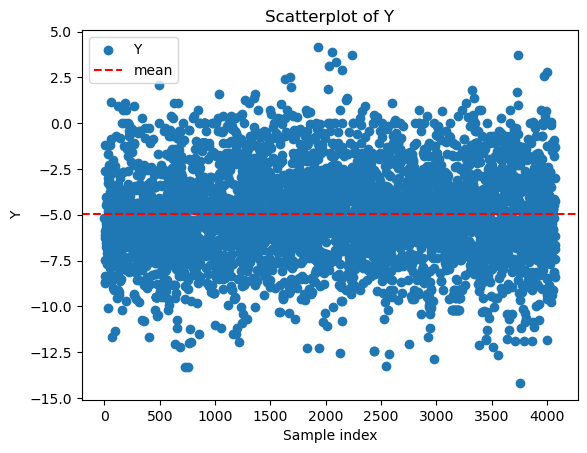

In [27]:
dummy = DummyRegressor()
CVTest(dummy, 'dummy', X, Y, data, reg_metrics_text)

#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

In [28]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_regressor = DecisionTreeRegressor()    # Try tuning on the hyperparameters: max_depth, min_samples_leaf, min_samples_split
CVTest(tree_regressor, 'tree', X, Y, data, reg_metrics_text)

Top 25 features based on mean importance over all folds:
                 Feature  Mean Importance
278          user.tweets         0.344599
279       user.following         0.183523
280           user.media         0.126585
268               quotes         0.084490
269           is.retweet         0.030039
281           n_hashtags         0.027218
277         user.website         0.015850
282              n_emoji         0.006534
271             pictures         0.006487
3                   food         0.006024
14                   yum         0.004535
272               videos         0.003221
274  multimedial_content         0.003159
24                  make         0.002574
211                thank         0.002467
64                  link         0.002439
97                   eat         0.002189
28                  time         0.002086
77                 everi         0.002007
62                  good         0.001954
20              culinari         0.001804
4                  

In [29]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_regressor = RandomForestRegressor(random_state=42)   # Try tuning on the hyperparameters: n_estimators, max_depth, min_samples_leaf, min_samples_split
CVTest(rf_regressor, 'rf', X, Y, data, reg_metrics_text)

Top 25 features based on mean importance over all folds:
                 Feature  Mean Importance
278          user.tweets         0.352669
279       user.following         0.185540
280           user.media         0.116480
268               quotes         0.087195
269           is.retweet         0.030246
281           n_hashtags         0.025890
277         user.website         0.016915
282              n_emoji         0.007581
3                   food         0.006060
271             pictures         0.005219
14                   yum         0.003518
274  multimedial_content         0.003496
272               videos         0.003027
276             user.bio         0.002559
211                thank         0.002386
97                   eat         0.002106
4                  foodi         0.001769
0                chicken         0.001661
16                  face         0.001655
20              culinari         0.001623
28                  time         0.001621
36                 

In [30]:
sv_regressor = SVR()    #Try tuning on the kernel
CVTest(sv_regressor, 'svm', X, Y, data, reg_metrics_text)

This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood           

In [31]:
knn_regressor = KNeighborsRegressor()       #Try tuning on the hyperparameters: n_neighbors, weights
CVTest(knn_regressor, 'knn', X, Y, data, reg_metrics_text)

This model does not provide feature importances.
This model does not provide feature importances.


This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
This model does not provide feature importances.
Top 25 features based on mean importance over all folds:
                     Feature  Mean Importance
0                    chicken              0.0
1                   fastfood              0.0
2                       fire              0.0
3                       food              0.0
4                      foodi              0.0
5                    foodpic              0.0
6                        fri              0.0
7                   homecook              0.0
8      homecookingvsfastfood              0.0
9   homecookingvsfastfoodcom              0.0
10                       hot              0.0

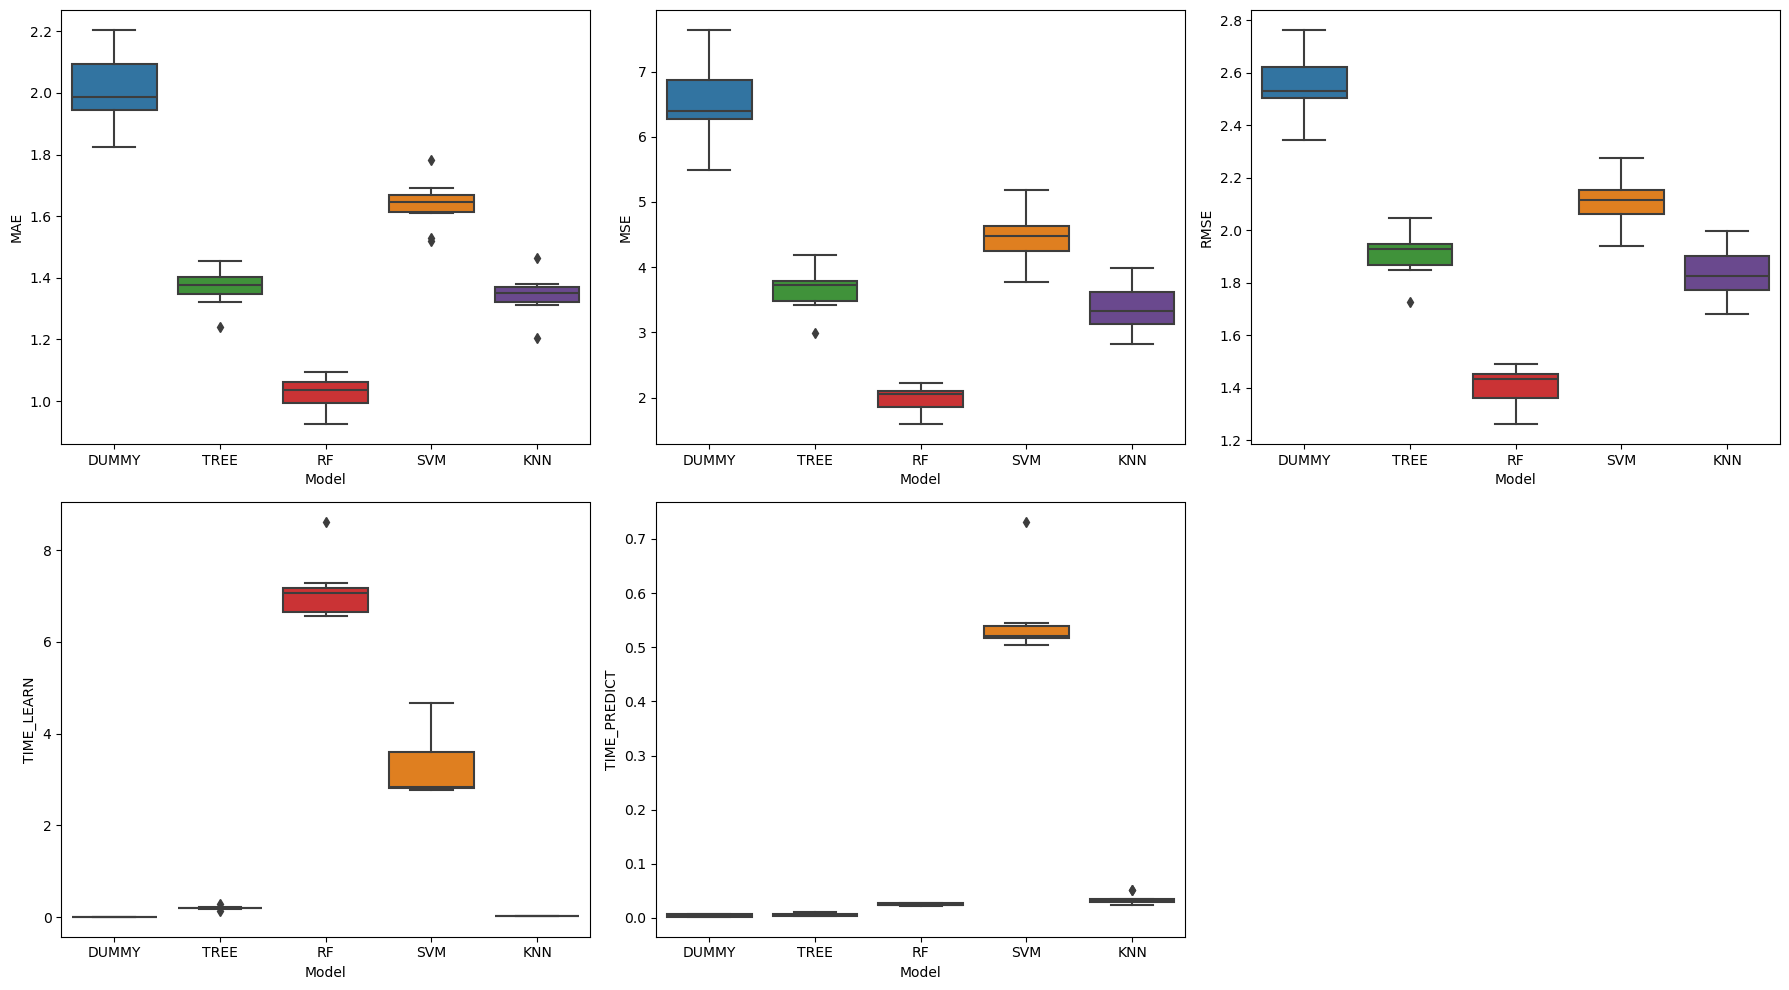

user.tweets


In [32]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
sns.boxplot(data=reg_metrics_text, x="Model", y="MAE", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="MSE", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="RMSE", ax=axs[0, 2], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_LEARN", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="Model", y="TIME_PREDICT", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])

# Hide the empty subplot (if any)
axs[1, 2].axis('off')



plt.tight_layout()
plt.show()

print(X.columns[278])